In [1]:
%load_ext autoreload
%autoreload 2

import sys, pickle
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

root_dir = Path.cwd()
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

from detection_algorithm_test.surrogate_data import SurrogateData
from utils import prepare_behavior_from_file, prepare_activity
# from HierarchicalBayesInference_analysis import HierarchicalBayesInference_analysis

In [ ]:
track = {
    'nbin': 40,
    'length': 100,
}

place_field_parameter = {
	'n_fields': 2,
    
    'A0': [0,2],
	'A': [0,5],
	'sigma': [1,5],
    'theta': [0,track['nbin']],
    
    'reliability': [0.3,1],
}

"""
	TODO:
		[ ] change way how mode numbers are generated: provide 3 values [0,1]:
			first value is prob for 0, second for 1, third for 2 modes
"""

In [3]:
pathSession = Path('../../../data/579ad/Session10')
# print([dir for dir in pathSession.iterdir()])
pathBehavior = pathSession / 'aligned_behavior.pkl'
behavior = prepare_behavior_from_file(pathBehavior,nbin=track['nbin'],f=15.)

In [4]:
# intensity_model = lambda x,parameter,fields : intensity_model_from_position(x=x,parameter=parameter,n_x=track['nbin'],fields=fields)

n_cells = 100
surrogate_data = SurrogateData(
    n_cells,track,
    place_field_parameter,behavior,
    place_cell_probability=1.)
# surrogate_data.tuning_curve_parameter

In [5]:
surrogate_data.generate_activity_all(nP=8)

>>> all done. time passed: 0.3966 secs <<<


In [6]:

data = {
	'tuning_curve_parameter': surrogate_data.tuning_curve_parameter,
	'behavior': behavior,
	'activity': surrogate_data.activity,
	'field_activation': surrogate_data.field_activation,
}
with open('surrogate_data_100.pkl','wb') as f:
	pickle.dump(surrogate_data,f)

In [4]:
with open('surrogate_data.pkl','rb') as f:
	surrogate_data = pickle.load(f)

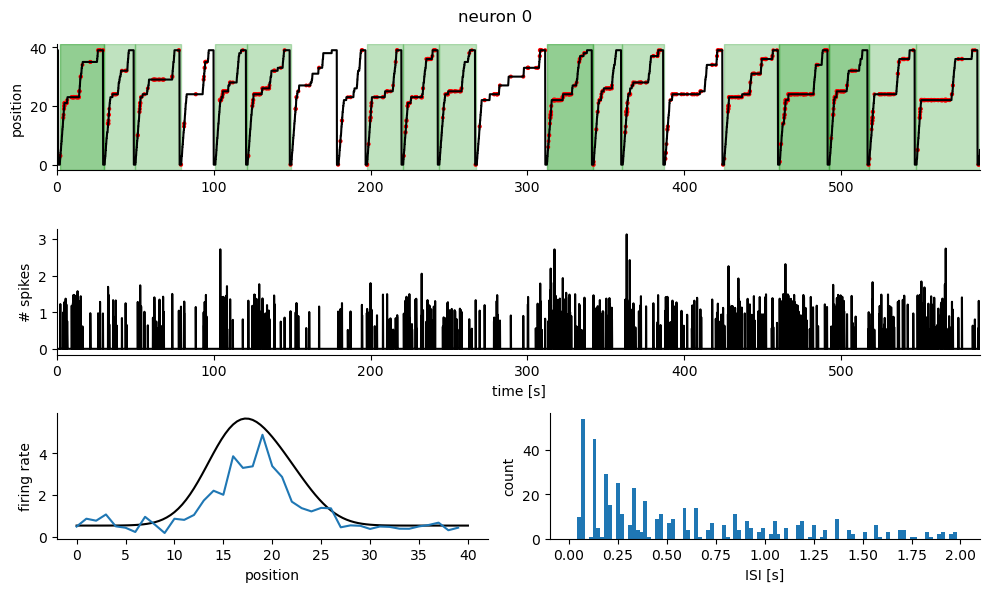

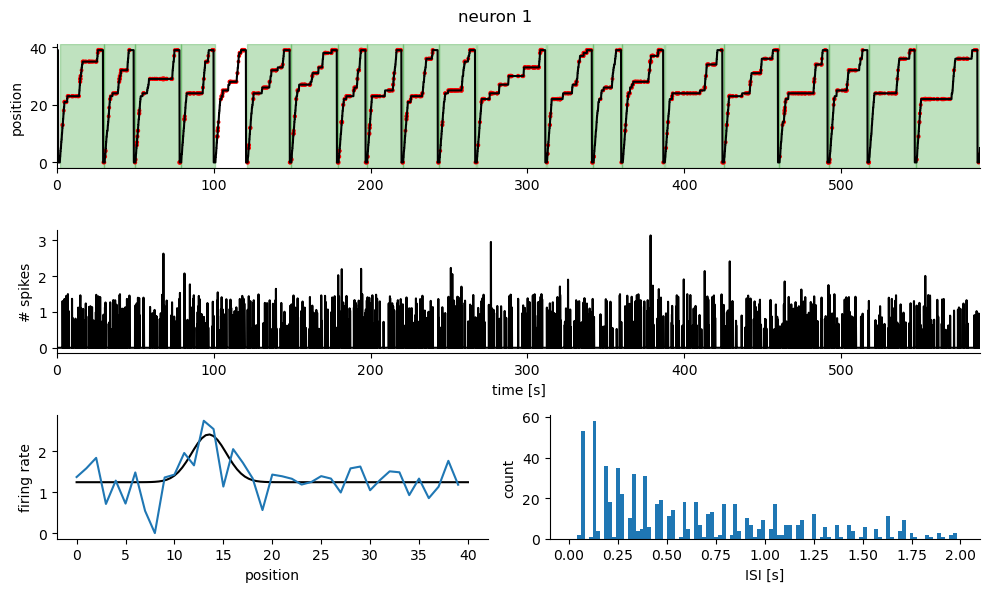

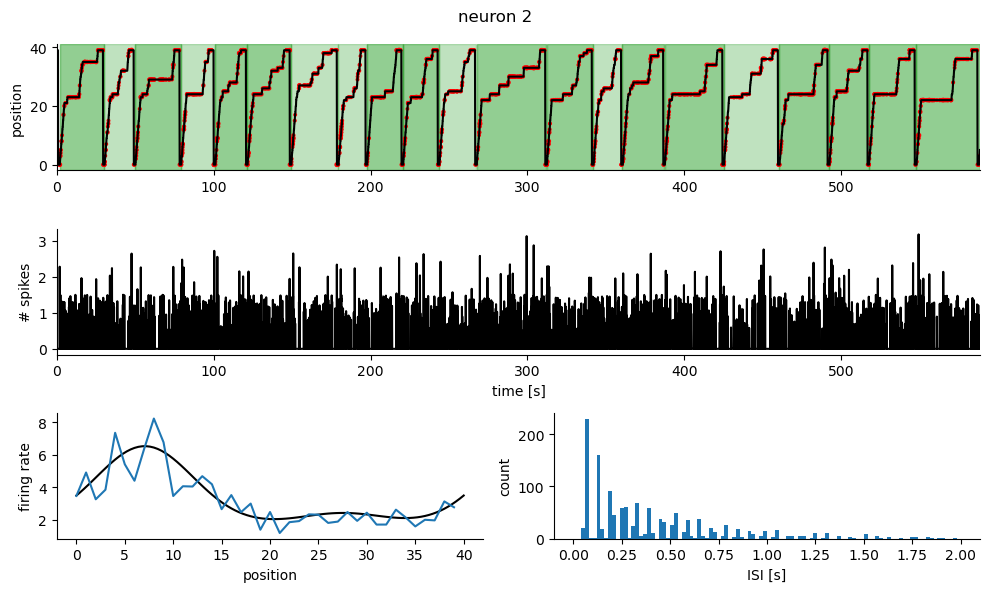

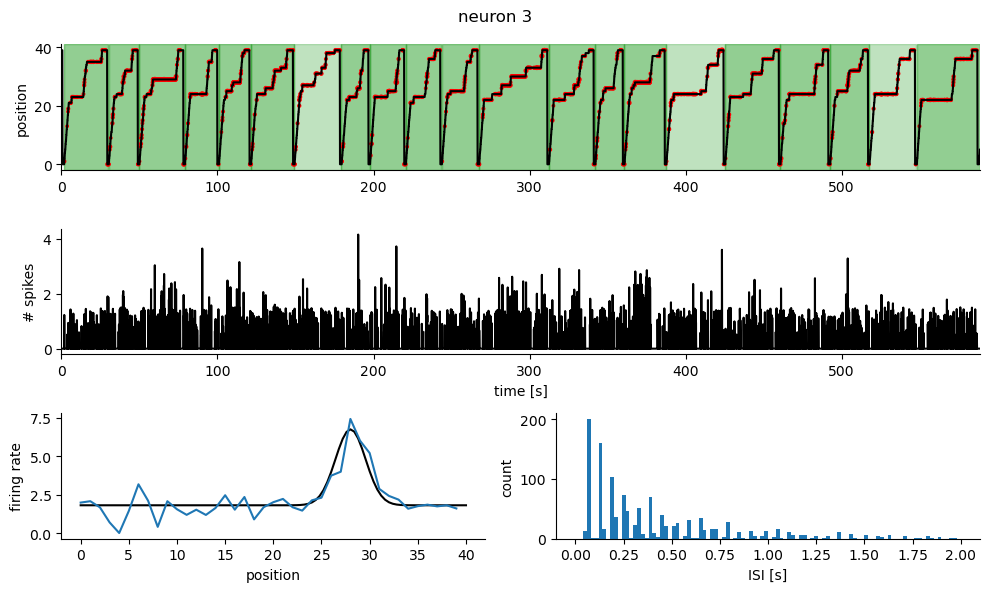

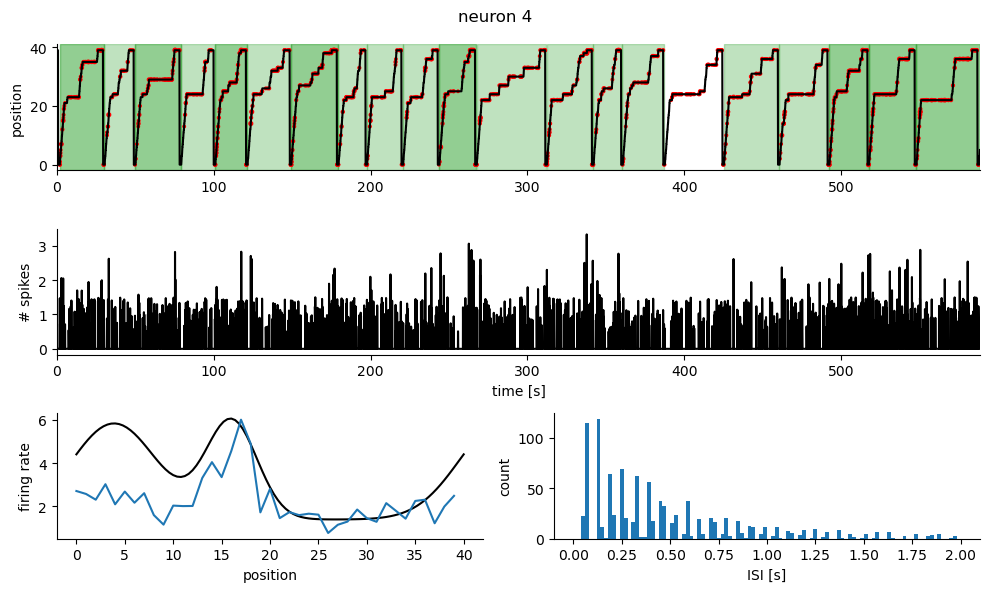

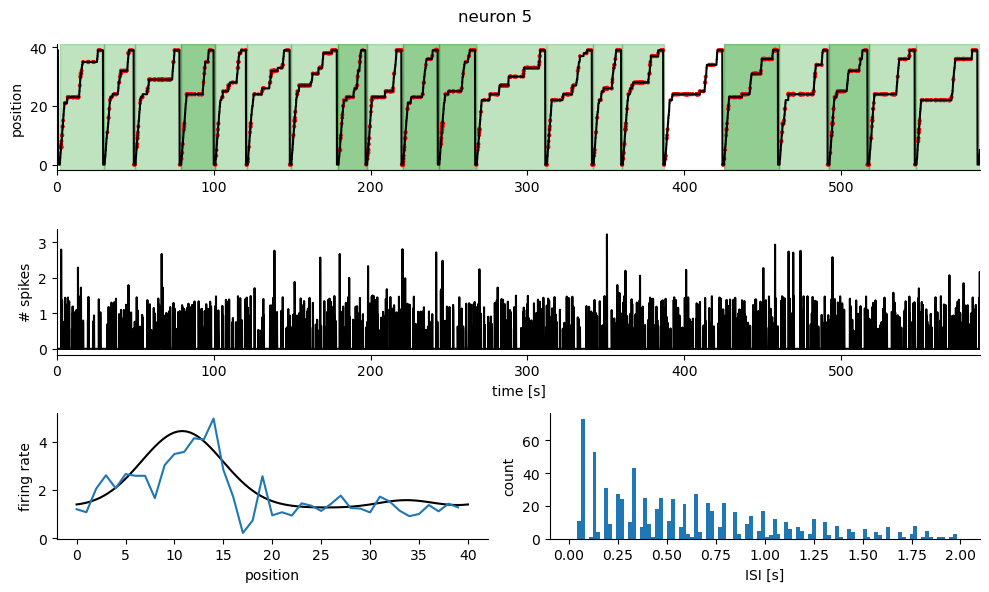

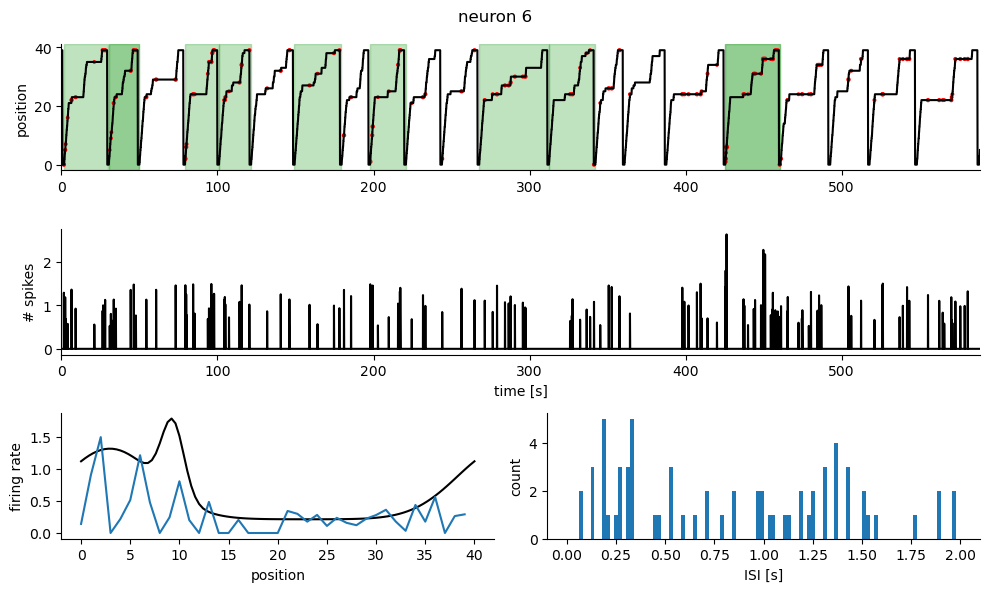

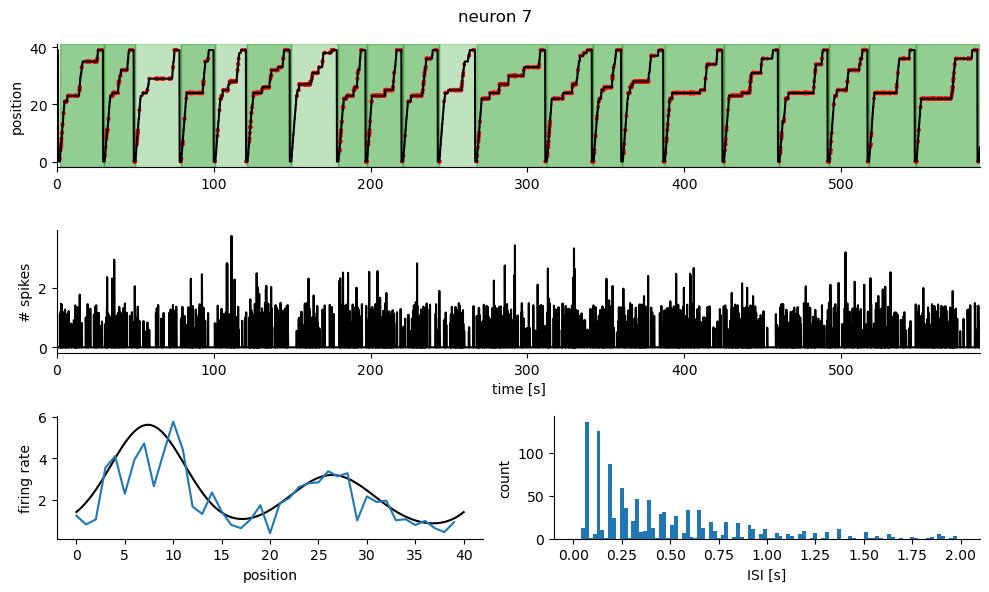

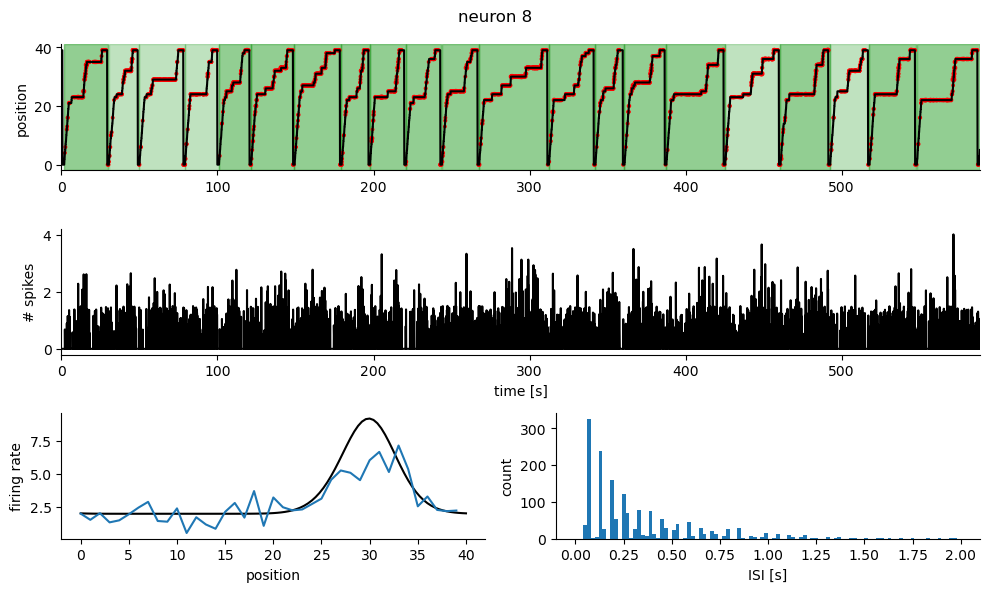

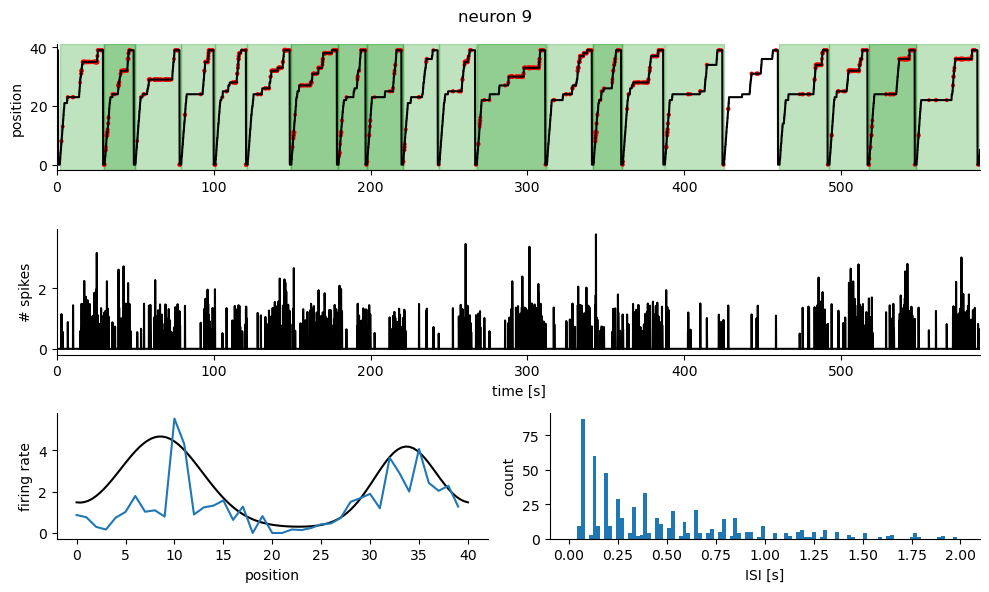

In [7]:
for n in range(10):
	surrogate_data.plot_activity(n)

In [124]:
from process_session import process_session

pathSession = Path('../../../data/579ad/Session10')
ps = process_session(plot_it=False)
results = ps.process_input(
    behavior,
    surrogate_data.activity,
    path_results = pathSession / 'surrogate_placefield_detection.hdf5',
    mode_place_cell_detection=['peak','information'],
    mode_place_field_detection=['bayesian'],
    # specific_n=np.arange(12),
    nP=12,
)

"""
	TODO:
		[ ] write analysis script for surrogate data comparing (including special case of closeby fields)
        [ ] add surrogate data with place field movement within session and test it!
        [ ] process large scale surrogate data on cluster (with "realistic" parameters)
        [ ] adjust plot-scripts and add potentially new analyses from peak detection, etc
        [ ] some sessions didnt process properly within 2h, while others run within 10 minutes
"""

run detection on 1000 neurons
Model comparison finished after 18.36s with evidences: 	 f=0 *, logz=-754.17	 f=1 , logz=-756.97
Model comparison finished after 77.77s with evidences: 	 f=0 , logz=-1085.22	 f=1 *, logz=-1038.76	 f=2 , logz=-1055.66
Model comparison finished after 80.87s with evidences: 	 f=0 , logz=-1095.67	 f=1 *, logz=-929.44	 f=2 , logz=-945.69
Model comparison finished after 85.92s with evidences: 	 f=0 , logz=-1088.80	 f=1 *, logz=-1070.99	 f=2 , logz=-1092.53
Model comparison finished after 89.36s with evidences: 	 f=0 , logz=-1025.25	 f=1 *, logz=-940.16	 f=2 , logz=-960.45
Model comparison finished after 91.63s with evidences: 	 f=0 , logz=-1346.20	 f=1 *, logz=-1041.05	 f=2 , logz=-1059.36
Model comparison finished after 94.22s with evidences: 	 f=0 , logz=-1588.86	 f=1 *, logz=-1224.54	 f=2 , logz=-1240.90
Model comparison finished after 129.64s with evidences: 	 f=0 , logz=-1431.45	 f=1 , logz=-1258.64	 f=2 *, logz=-1185.20
Model comparison finished after 138.

In [7]:
from utils import load_data
results = load_data(pathSession / 'surrogate_placefield_detection.hdf5')

In [8]:
is_PC = results['status']['is_place_cell']

for key in is_PC.keys():
	print(key,is_PC[key].sum())

peak_n_info = (is_PC['peak_method'] & is_PC['information_method']).sum()
peak_n_bayes = (is_PC['peak_method'] & is_PC['bayesian_method']).sum()
info_n_bayes = (is_PC['information_method'] & is_PC['bayesian_method']).sum()
peak_n_info_n_bayes = (is_PC['peak_method'] & is_PC['information_method'] & is_PC['bayesian_method']).sum()

print(f"{peak_n_info} neurons are detected as place cells by both peak and information method")
print(f"{peak_n_bayes} neurons are detected as place cells by both peak and bayesian method")
print(f"{info_n_bayes} neurons are detected as place cells by both information and bayesian method")
print(f"{peak_n_info_n_bayes} neurons are detected as place cells by all methods")

bayesian_method 976
information_method 245
peak_method 382
stability_method 0
160 neurons are detected as place cells by both peak and information method
378 neurons are detected as place cells by both peak and bayesian method
245 neurons are detected as place cells by both information and bayesian method
160 neurons are detected as place cells by all methods


## Handover data from surrogate and inferred in a structured way

In [393]:
from utils.utils_analysis import thresholded_linear_sum_assignment

n_cells = len(surrogate_data.tuning_curve_parameter)

parameters_bare = {
	'A0': np.full(n_cells,np.NaN),
	'n_fields': np.full(n_cells,-1,'int'),
	'A': np.full((n_cells,2),np.NaN),
	'sigma': np.full((n_cells,2),np.NaN),
	'theta': np.full((n_cells,2),np.NaN),
	'reliability': np.full((n_cells,2),np.NaN),
}

for n, neuron in enumerate(surrogate_data.tuning_curve_parameter):
	parameters_bare['n_fields'][n] = neuron['n_fields']
	parameters_bare['A0'][n] = neuron['A0']
	for f, field in enumerate(neuron['PF']):
		parameters_bare['A'][n,f] = field['A']
		parameters_bare['sigma'][n,f] = field['sigma']
		parameters_bare['theta'][n,f] = field['theta']
		parameters_bare['reliability'][n,f] = field['reliability']
	

parameters = {
	'truth': {
		'n_fields': np.full(n_cells,-1,'int'),
		'A0': np.full(n_cells,np.NaN),
		'matched': {
			'n_fields': np.full(n_cells,-1,'int'),
			'A': np.full((n_cells,2),np.NaN),
			'sigma': np.full((n_cells,2),np.NaN),
			'theta': np.full((n_cells,2),np.NaN),
			'reliability': np.full((n_cells,2),np.NaN),
		},
		'nonmatched': {
			'A': np.full((n_cells,2),np.NaN),
			'sigma': np.full((n_cells,2),np.NaN),
			'theta': np.full((n_cells,2),np.NaN),
			'reliability': np.full((n_cells,2),np.NaN),
		}
	},
	'inferred': {
		'n_fields': np.full(n_cells,-1,'int'),
		'A0': np.full(n_cells,np.NaN),
		'matched': {
			'n_fields': np.full(n_cells,-1,'int'),
			'A': np.full((n_cells,2),np.NaN),
			'sigma': np.full((n_cells,2),np.NaN),
			'theta': np.full((n_cells,2),np.NaN),
			'reliability': np.full((n_cells,2),np.NaN),
		},
		'nonmatched': {
			'A': np.full((n_cells,2),np.NaN),
			'sigma': np.full((n_cells,2),np.NaN),
			'theta': np.full((n_cells,2),np.NaN),
			'reliability': np.full((n_cells,2),np.NaN),
		}
	},
	'field_match': np.full((n_cells,2), -1, "int"),
}

nbin = 40
for n,cell in enumerate(surrogate_data.tuning_curve_parameter):
    

	## find matching field
	if (cell['n_fields']>0) and (results['fields']['n_modes'][n]>0):
		dTheta = np.zeros((cell['n_fields'],results['fields']['n_modes'][n]))
		for f in range(results["fields"]["n_modes"][n]):
			theta = results["fields"]["parameter"]["global"]["theta"][n,f,0]

			for f_truth, field in enumerate(cell["PF"]):

				dTheta[f_truth,f] = abs(
					np.mod(theta - field["theta"] + nbin / 2.0, nbin) - nbin / 2.0
				)
		matched_truth, matched_inferred, nonmatched_truth, nonmatched_inferred = thresholded_linear_sum_assignment(dTheta,5)
		
		parameters['field_match'][n,matched_inferred] = matched_truth
		
	elif (cell['n_fields']>0):
		matched_truth = matched_inferred = []
		nonmatched_truth = np.arange(cell['n_fields'])
		nonmatched_inferred = []

	elif (results['fields']['n_modes'][n]>0):
		matched_truth = matched_inferred = []
		nonmatched_truth = []
		nonmatched_inferred = np.arange(results['fields']['n_modes'][n])
	else:
		matched_truth = matched_inferred = []
		nonmatched_truth = nonmatched_inferred = []

	parameters['truth']['n_fields'][n] = cell['n_fields']
	parameters['inferred']['n_fields'][n] = results['fields']['n_modes'][n]

	parameters['truth']['A0'][n] = cell['A0']
	parameters['inferred']['A0'][n] = results['fields']['parameter']['global']['A0'][n,0]

	parameters['truth']['matched']['n_fields'][n] = len(matched_truth)
	for f_truth in matched_truth:
		parameters['truth']['matched']['sigma'][n,f_truth] = cell['PF'][f_truth]['sigma']
		parameters['truth']['matched']['theta'][n,f_truth] = cell['PF'][f_truth]['theta']
		parameters['truth']['matched']['A'][n,f_truth] = cell['PF'][f_truth]['A']
		# parameters['truth']['matched']['reliability'][n,f_truth] = cell['PF'][f_truth]['reliability']
		parameters['truth']['matched']['reliability'][n,f_truth] = surrogate_data.field_activation[n,f_truth].mean()
	
	for f_truth in nonmatched_truth:
		parameters['truth']['nonmatched']['sigma'][n,f_truth] = cell['PF'][f_truth]['sigma']
		parameters['truth']['nonmatched']['theta'][n,f_truth] = cell['PF'][f_truth]['theta']
		parameters['truth']['nonmatched']['A'][n,f_truth] = cell['PF'][f_truth]['A']
		# parameters['truth']['nonmatched']['reliability'][n,f_truth] = cell['PF'][f_truth]['reliability']
		parameters['truth']['nonmatched']['reliability'][n,f_truth] = surrogate_data.field_activation[n,f_truth].mean()
	
	parameters['inferred']['matched']['n_fields'][n] = len(matched_inferred)
	for f_inferred in matched_inferred:
		idx_match = parameters['field_match'][n,f_inferred]
		parameters['inferred']['matched']['sigma'][n,idx_match] = results['fields']['parameter']['global']['sigma'][n,f_inferred,0]
		parameters['inferred']['matched']['theta'][n,idx_match] = results['fields']['parameter']['global']['theta'][n,f_inferred,0]
		parameters['inferred']['matched']['A'][n,idx_match] = results['fields']['parameter']['global']['A'][n,f_inferred,0]
		parameters['inferred']['matched']['reliability'][n,idx_match] = results['fields']['reliability'][n,f_inferred]
	
	for f_inferred in nonmatched_inferred:
		parameters['inferred']['nonmatched']['sigma'][n,f_inferred] = results['fields']['parameter']['global']['sigma'][n,f_inferred,0]
		parameters['inferred']['nonmatched']['theta'][n,f_inferred] = results['fields']['parameter']['global']['theta'][n,f_inferred,0]
		parameters['inferred']['nonmatched']['A'][n,f_inferred] = results['fields']['parameter']['global']['A'][n,f_inferred,0]
		parameters['inferred']['nonmatched']['reliability'][n,f_inferred] = results['fields']['reliability'][n,f_inferred]


In [394]:
surrogate_data.field_activation[0].mean(axis=1)

array([0.47619048, 0.85714286])

## Plot analysis of test runs

define functions and some basic arrays for further processing

In [395]:
def plot_histogram_offset(ax,data,bins,density=False,width=None,offset=0,**kwargs):
	counts,_ = np.histogram(data,bins=bins,density=density)
	ax.bar(bins[:-1]+offset,counts,width=width,align='edge',**kwargs)

bins_fields = np.linspace(-0.5,2.5,4)
fields_match = parameters['truth']['matched']['n_fields'] == parameters['truth']['n_fields']
w = 0.2


### Distribution of place field parameters from surrogate data

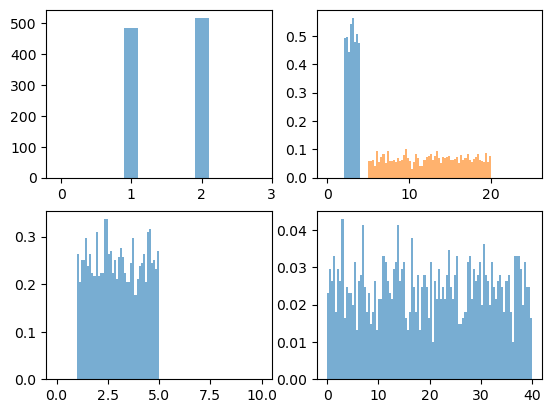

In [396]:
fig = plt.figure()

ax = fig.add_subplot(221)
plot_histogram_offset(ax,parameters['truth']['n_fields'],bins=bins_fields,width=w,offset=0.4,alpha=0.6,label='peak',color='tab:blue')

# ax.hist(parameters['truth']['n_fields'],bins=np.arange(4)-w/2,width=w,align='mid')
plt.setp(ax,xticks=np.linspace(0,3,4))

ax = fig.add_subplot(222)
max_val = 25.

bins = np.linspace(0,max_val,101)
ax.hist(parameters['truth']['A0'],bins=bins,density=True,alpha=0.6)
A = parameters_bare['A'].flatten()
ax.hist(A,bins=bins,density=True,alpha=0.6)
# ax.hist(parameters['truth']['matched']['A'][:,1],bins=bins,density=True,alpha=0.6)

ax = fig.add_subplot(223)
sigma = parameters_bare['sigma'].flatten()
ax.hist(sigma,bins=np.linspace(0,10,101),density=True,alpha=0.6)

ax = fig.add_subplot(224)
theta = parameters_bare['theta'].flatten()
ax.hist(theta,bins=np.linspace(0,track['nbin'],101),density=True,alpha=0.6)

plt.show(block=False)

### Analyze parameter-dependent inference results of Bayesian analysis 

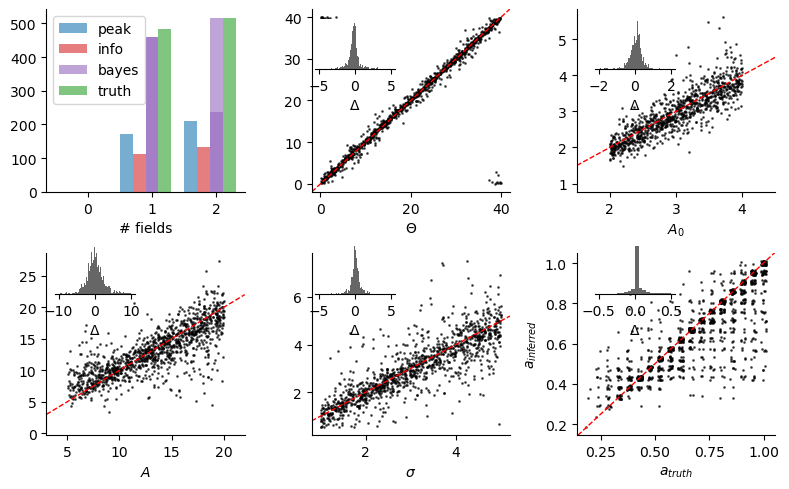

In [654]:

fig = plt.figure(figsize=(8,5))

ax_detection_rate = fig.add_subplot(231)
bins = np.linspace(-0.5,2.5,4)
plot_histogram_offset(ax_detection_rate,parameters['truth']['n_fields'][is_PC['peak_method']],bins=bins,width=w,offset=0,alpha=0.6,label='peak',color='tab:blue')
plot_histogram_offset(ax_detection_rate,parameters['truth']['n_fields'][is_PC['information_method']],bins=bins,width=w,offset=+w,alpha=0.6,label='info',color='tab:red')
plot_histogram_offset(ax_detection_rate,parameters['truth']['n_fields'][is_PC['bayesian_method']],bins=bins,width=w,offset=2*w,alpha=0.6,label='bayes',color='tab:purple')
plot_histogram_offset(ax_detection_rate,parameters['truth']['n_fields'][fields_match],bins=bins,width=w,offset=2*w,alpha=0.6,color='tab:purple')#,label='bayes')
plot_histogram_offset(ax_detection_rate,parameters['truth']['n_fields'],bins=bins,width=w,offset=3*w,alpha=0.6,label='truth',color='tab:green')
plt.setp(ax_detection_rate,xlabel='# fields')
ax_detection_rate.legend()
### could add: sensitivity vs specificity?!


ax_theta = fig.add_subplot(232)
ax_theta_hist = fig.add_subplot([0.4,0.85,0.1,0.1])

ax_theta.axline((1, 1), slope=1,color='r',ls='--',lw=1)
ax_theta.scatter(parameters['truth']['matched']['theta'].flatten(),parameters['inferred']['matched']['theta'].flatten(),alpha=0.6,s=1,c='k')
plt.setp(ax_theta,xlabel='$\Theta$')

dTheta = parameters['truth']['matched']['theta'] - parameters['inferred']['matched']['theta']
dTheta = dTheta[np.isfinite(dTheta)]
ax_theta_hist.hist(dTheta,bins=np.linspace(-5,5,101),density=True,alpha=0.6,color='k')


ax_baseline = fig.add_subplot(233)
ax_baseline_hist = fig.add_subplot([0.75,0.85,0.1,0.1])

ax_baseline.axline((1, 1), slope=1,color='r',ls='--',lw=1)
ax_baseline.scatter(parameters['truth']['A0'],parameters['inferred']['A0'],alpha=0.6,s=1,c='k')
plt.setp(ax_baseline,xlim=[1.5,4.5],xlabel='$A_0$')

ax_baseline_hist.hist(parameters['truth']['A0']-parameters['inferred']['A0'],bins=np.linspace(-2,2,101),density=True,alpha=0.6,color='k')


ax_amplitude = fig.add_subplot(234)
ax_amplitude_hist = fig.add_subplot([0.075,0.4,0.1,0.1])

ax_amplitude.axline((1, 1), slope=1,color='r',ls='--',lw=1)
ax_amplitude.scatter(parameters['truth']['matched']['A'].flatten(),parameters['inferred']['matched']['A'].flatten(),alpha=0.6,s=1,c='k')
plt.setp(ax_amplitude,xlabel='$A$',xlim=[3,22])

dA = parameters['truth']['matched']['A'] - parameters['inferred']['matched']['A']
dA = dA[np.isfinite(dA)]
ax_amplitude_hist.hist(dA,bins=np.linspace(-10,10,101),density=True,alpha=0.6,color='k')
ax_amplitude_hist.spines[['top','right']].set_visible(False)


ax_sigma = fig.add_subplot(235)
ax_sigma_hist = fig.add_subplot([0.4,0.4,0.1,0.1])

ax_sigma.axline((1, 1), slope=1,color='r',ls='--',lw=1)
ax_sigma.scatter(parameters['truth']['matched']['sigma'].flatten(),parameters['inferred']['matched']['sigma'].flatten(),alpha=0.6,s=1,c='k')
plt.setp(ax_sigma,xlabel='$\sigma$')

dSigma = parameters['truth']['matched']['sigma'] - parameters['inferred']['matched']['sigma']
dSigma = dSigma[np.isfinite(dSigma)]
ax_sigma_hist.hist(dSigma,bins=np.linspace(-5,5,101),density=True,alpha=0.6,color='k')


ax_reliability = fig.add_subplot(236)
ax_reliability_hist = fig.add_subplot([0.75,0.4,0.1,0.1])

scatter = (np.random.rand(2*n_cells,2)-1/2.) * 1/behavior['trials']['ct']*0.5
ax_reliability.axline((1, 1), slope=1,color='r',ls='--',lw=1)
ax_reliability.scatter(scatter[:,0]+parameters['truth']['matched']['reliability'].flatten(),scatter[:,1]+parameters['inferred']['matched']['reliability'].flatten(),alpha=0.6,s=1,c='k')
plt.setp(ax_reliability,xlabel='$a_{truth}$',ylabel='$a_{inferred}$')

dReliability = parameters['truth']['matched']['reliability'] - parameters['inferred']['matched']['reliability']
dReliability = dReliability[np.isfinite(dReliability)]
ax_reliability_hist.hist(dReliability,bins=np.linspace(-0.5,0.5,21),density=True,alpha=0.6,color='k')


for axx in [ax_detection_rate,ax_theta,ax_baseline,ax_amplitude,ax_sigma,ax_reliability]:
	axx.spines[['top','right']].set_visible(False)

for axx in [ax_theta_hist,ax_baseline_hist,ax_amplitude_hist,ax_sigma_hist,ax_reliability_hist]:
	axx.spines[['top','right','left']].set_visible(False)
	plt.setp(axx,yticks=[],xlabel='$\Delta$')


# ax = fig.add_subplot([0.6,0.35,0.1,0.1])
# dTheta = parameters['truth']['matched']['theta'] - parameters['inferred']['matched']['theta']
# dTheta = dTheta[np.isfinite(dTheta)]
# ax.hist(dTheta,bins=np.linspace(-5,5,101),density=True,alpha=0.6)
# ax.hist(np.abs(parameters['truth']['matched']['theta'][:,0]-parameters['inferred']['matched']['theta'][:,0]),bins=np.linspace(0,5,101),density=True,cumulative=True,histtype='step',color='k')

# ax.hist(np.abs(parameters['truth']['matched']['theta'][:,1]-parameters['inferred']['matched']['theta'][:,1]),bins=np.linspace(0,5,101),density=True,alpha=0.6)
# ax.hist(np.abs(parameters['truth']['matched']['theta'][:,1]-parameters['inferred']['matched']['theta'][:,1]),bins=np.linspace(0,5,101),density=True,cumulative=True,histtype='step',color='k')
plt.tight_layout()
plt.show(block=False)


In [398]:
# fig = plt.figure()
# ax = fig.add_subplot(221)
# ax.hist(np.abs(parameters['truth']['nonmatched']['theta'][:,0],parameters['inferred']['A0']),bins=np.linspace(0,5,101),density=True,alpha=0.6)

n_modes_match = parameters['inferred']['n_fields'] == parameters['truth']['n_fields']

fields_match = parameters['truth']['matched']['n_fields'] == parameters['truth']['n_fields']

print(f'same number of modes: {n_modes_match.sum()}, all modes correct: {fields_match.sum()}')


same number of modes: 696, all modes correct: 695


In [399]:
failed_2mode = np.logical_and(parameters['truth']['n_fields'] == 2, parameters['truth']['matched']['n_fields'] != 2)
failed_2mode_0 = np.logical_and(failed_2mode, results['fields']['n_modes'] == 0)
failed_2mode_1 = np.logical_and(failed_2mode, results['fields']['n_modes'] == 1)
failed_2mode_2 = np.logical_and(failed_2mode, results['fields']['n_modes'] == 2)

failed_1mode = np.logical_and(parameters['truth']['n_fields'] == 1, results['fields']['n_modes'] != 1)
failed_1mode_0 = np.logical_and(failed_1mode, results['fields']['n_modes'] == 0)
failed_1mode_1 = np.logical_and(failed_1mode, results['fields']['n_modes'] == 1)
failed_1mode_2 = np.logical_and(failed_1mode, results['fields']['n_modes'] == 2)

print(f'Failed 2 mode: {failed_2mode.sum()},\t 0 mode: {failed_2mode_0.sum()}, \t 1 mode: {failed_2mode_1.sum()}, \t 2 mode: {failed_2mode_2.sum()}')
print(f'Failed 1 mode: {failed_1mode.sum()},\t 0 mode: {failed_1mode_0.sum()}, \t 1 mode: {failed_1mode_1.sum()}, \t 2 mode: {failed_1mode_2.sum()}')

Failed 2 mode: 281,	 0 mode: 0, 	 1 mode: 280, 	 2 mode: 1
Failed 1 mode: 24,	 0 mode: 24, 	 1 mode: 0, 	 2 mode: 0


In [410]:
from scipy.special import erf
from utils.utils_analysis import gauss_smooth

def norm_cdf(x, mu, sigma):
    return 0.5 * (1.0 + erf((x - mu) / (np.sqrt(2) * sigma)))

all_2modes = parameters_bare['n_fields'] == 2
nbin=40
close_threshold = [0.3,0.5]

overlap = np.full((n_cells,2),np.NaN)
d_theta = np.full(n_cells,np.NaN)
idx_overlap = np.zeros(n_cells,'bool')
for n in np.where(all_2modes)[0]:	
	
	d_theta[n] = np.mod(np.diff(parameters_bare['theta'][n,:])+nbin/2,nbin)-nbin/2
	overlap_range = -abs(d_theta[n]) + 2*parameters_bare['sigma'][n,:].sum()

	for f in range(2):
		overlap[n,f] = norm_cdf(overlap_range - 2 * parameters_bare['sigma'][n,f], 0, parameters_bare['sigma'][n,f])

	if np.all(overlap[n,:] > close_threshold[0]) and np.any(overlap[n,:] > close_threshold[1]):

		# print(f"neuron {n} failed to detect 2 modes, dTheta={d_theta[n]} overlap: {overlap[n]}")
		# print(f"neuron {n} failed to detect 2 modes, dTheta={theta_2-theta_1} overlap: {ol_1} and {ol_2}")
		idx_overlap[n] = True

idx_detected = fields_match & (parameters_bare['n_fields']==2)
idx_separated = failed_2mode_1 & ~idx_overlap

print(f"too close: {idx_overlap.sum()}")


def plot_vars(ax,var,bins):

	params_matched = parameters['truth'] if var=='A0' else parameters['truth']['matched']
	params_nonmatched = parameters['truth'] if var=='A0' else parameters['truth']['nonmatched']

	fact = 1 if var=='A0' else 2

	vals = np.full((2*n_cells,3),np.NaN)
	vals[:fact*idx_separated.sum(),0] = params_nonmatched[var][idx_separated].flatten()
	vals[:fact*idx_overlap.sum(),1] = params_nonmatched[var][idx_overlap].flatten()
	vals[:fact*idx_detected.sum(),2] = params_matched[var][idx_detected].flatten()

	ax.hist(vals,bins=bins,alpha=0.6,color=['tab:red','tab:olive','tab:green'],label=['separated','overlapping','detected'],histtype='bar',stacked=True)

	values = np.full((len(bins)-1,3),np.NaN)
	for i in range(3):
		values[:,i], x = np.histogram(vals[:,i],bins=bins)
	
	plt.setp(ax,xlabel=var,yticks=[])
	ax.spines[['top','left','right']].set_visible(False)

	ax_fraction = ax.twinx()
	ax_fraction.plot(bins[:-1],gauss_smooth(values[:,0]/values.sum(axis=1),1,mode='constant'),color='tab:red',label='separated')
	ax_fraction.plot(bins[:-1],gauss_smooth(values[:,1]/values.sum(axis=1),1,mode='constant'),color='k',label='overlapping')
	plt.setp(ax_fraction,ylim=[0,1])
	ax_fraction.spines[['top','left']].set_visible(False)

def get_filtered_values(val):

	return {
		'detected': parameters['truth']['matched'][val][idx_detected,:],
		'overlap': parameters['truth']['nonmatched'][val][idx_overlap,:],
		'separated': parameters['truth']['nonmatched'][val][idx_separated,:],
	}


too close: 161


/tmp/ipykernel_8086/2878965064.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_theta[n] = np.mod(np.diff(parameters_bare['theta'][n,:])+nbin/2,nbin)-nbin/2


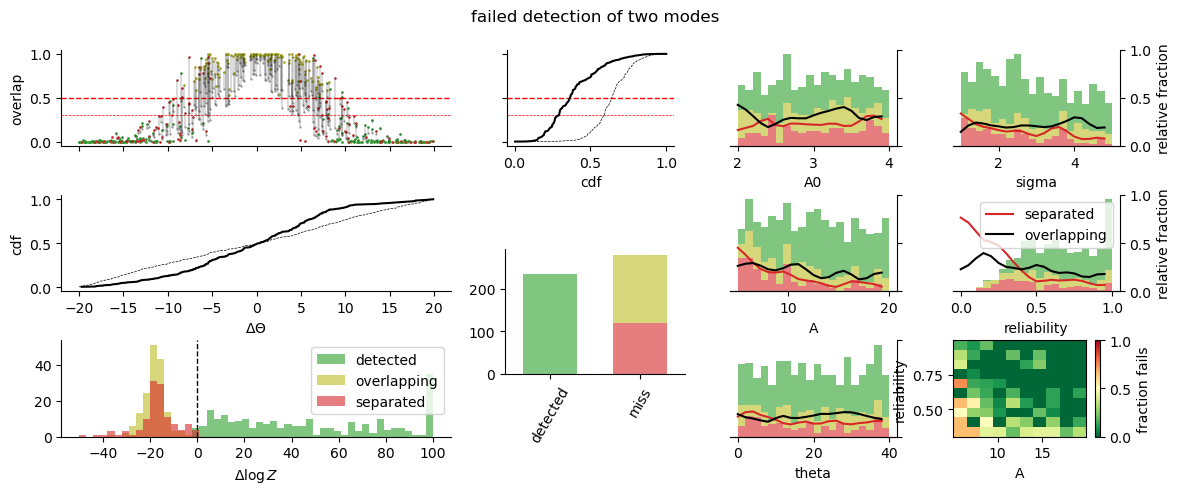

In [657]:
from utils import ecdf

gs = plt.GridSpec(3,5)
fig = plt.figure(figsize=(12,5))
ax_close = fig.add_subplot(gs[0,:2])
ax_close.axhline(close_threshold[0],color='r',ls='--',lw=0.5)
ax_close.axhline(close_threshold[1],color='r',ls='--',lw=1)
ax_close.plot(np.tile(d_theta[np.newaxis,:],(2,1)),overlap.T,'-',linewidth=0.2,color='k',label='field 1')
ax_close.scatter(d_theta,overlap[:,0],s=1,c='tab:grey',marker='.')
ax_close.scatter(d_theta,overlap[:,1],s=1,c='tab:grey',marker='.')

# ax_close.scatter(d_theta,np.max(overlap,axis=1),s=1,c='k',marker='.')
ax_close.scatter(d_theta[idx_detected],np.max(overlap[idx_detected,:],axis=1),s=2,c='tab:green',marker='.')
ax_close.scatter(d_theta[idx_overlap],np.max(overlap[idx_overlap,:],axis=1),s=2,c='tab:olive',marker='.')
ax_close.scatter(d_theta[idx_separated],np.max(overlap[idx_separated,:],axis=1),s=2,c='tab:red',marker='.')

plt.setp(ax_close,ylabel='overlap')
plt.setp(ax_close.get_xticklabels(),visible=False)
ax_close.spines[['top','right']].set_visible(False)


ax_overlap = fig.add_subplot(gs[0,2],sharey=ax_close)
ax_overlap.axhline(close_threshold[0],color='r',ls='--',lw=0.5)
ax_overlap.axhline(close_threshold[1],color='r',ls='--',lw=1)
x,y = ecdf(np.max(overlap[all_2modes,:],axis=1))
ax_overlap.plot(y,x,color='k',linestyle='--',linewidth=0.5)

x,y = ecdf(np.max(overlap[failed_2mode_1,:],axis=1))
ax_overlap.plot(y,x,color='k')

plt.setp(ax_overlap,xlabel='cdf')
plt.setp(ax_overlap.get_yticklabels(),visible=False)
ax_overlap.spines[['top','right']].set_visible(False)

ax_theta = fig.add_subplot(gs[1,:2],sharex=ax_close)
x,y = ecdf(d_theta[all_2modes])
ax_theta.plot(x,y,color='k',linestyle='--',linewidth=0.5)

x,y = ecdf(d_theta[failed_2mode_1])
ax_theta.plot(x,y,color='k')

plt.setp(ax_theta,xlabel='$\Delta\Theta$',ylabel='cdf')

ax_numbers = fig.add_subplot([0.425,0.25,0.15,0.25])
numbers = [idx_detected.sum(),idx_separated.sum()]

bottom = np.zeros(2)

ax_numbers.bar([0,1],numbers,color=['tab:green','tab:red'],bottom=bottom,width=0.6,label=[None,'separated'],alpha=0.6)
ax_numbers.bar([1],idx_overlap.sum(),color='tab:olive',bottom=numbers[1],width=0.6,label='overlapping',alpha=0.6)
plt.setp(ax_numbers,xticks=[0,1],xticklabels=['detected','miss'],xlim=[-0.5,1.5])#,ylim=[0,800])
plt.setp(ax_numbers.xaxis.get_majorticklabels(),rotation=60)

# 'separated'
# ax_numbers.legend(fontsize=8,loc='lower left')

for axx in [ax_close,ax_overlap,ax_theta,ax_numbers]:
	axx.spines[['top','right']].set_visible(False)


dlogz = np.diff(results['fields']['logz'][:,1:,0])
bins=np.linspace(-50,100,51)

ax = fig.add_subplot(gs[2,:2])
ax.axvline(0,color='k',ls='--',lw=1)
ax.hist(np.clip(dlogz[np.logical_and(all_2modes,results['fields']['n_modes']==2)],a_min=None,a_max=100),bins=bins,alpha=0.6,color='tab:green',label='detected')#,bins=np.linspace(-10,10,101),density=True,alpha=0.6)
ax.hist(dlogz[np.logical_and(np.logical_and(all_2modes,results['fields']['n_modes']==1),idx_overlap)],bins=bins,alpha=0.6,color='tab:olive',label='overlapping')#,bins=np.linspace(-10,10,101),density=True,alpha=0.6)#
ax.hist(dlogz[np.logical_and(np.logical_and(all_2modes,results['fields']['n_modes']==1),~idx_overlap)],bins=bins,alpha=0.6,color='tab:red',label='separated')#,bins=np.linspace(-10,10,101),density=True,alpha=0.6)

plt.setp(ax,xlabel='$\Delta \log Z$')
ax.legend()
ax.spines[['top','right']].set_visible(False)


plot_vars(fig.add_subplot(gs[0,3]),'A0',np.linspace(2,4,21))
plt.setp(plt.gca(),yticklabels=[])

plot_vars(fig.add_subplot(gs[1,3]),'A',np.linspace(5,20,21))
plt.setp(plt.gca(),yticklabels=[])

plot_vars(fig.add_subplot(gs[2,3]),'theta',np.linspace(0,40,21))
plt.setp(plt.gca(),yticklabels=[])

plot_vars(fig.add_subplot(gs[0,4]),'sigma',np.linspace(1,5,21))
plt.setp(plt.gca(),ylabel='relative fraction')

plot_vars(fig.add_subplot(gs[1,4]),'reliability',np.linspace(0,1.,21))
plt.setp(plt.gca(),ylabel='relative fraction')
plt.gca().legend()

steps = 10
keys = ['A','reliability']

x = get_filtered_values(keys[0])
y = get_filtered_values(keys[1])

x_array = np.linspace(np.nanmin(parameters_bare[keys[0]]),np.nanmax(parameters_bare[keys[0]]),steps+1)
y_array = np.linspace(np.nanmin(parameters_bare[keys[1]]),np.nanmax(parameters_bare[keys[1]]),steps+1)

A_ct = np.zeros((3,steps,steps))
for i in range(steps):
	for j in range(steps):
		for id,idx in enumerate(x.keys()):
			A_ct[id,i,j] = np.logical_and((x[idx]>x_array[i])&(x[idx]<x_array[i+1]),(y[idx]>y_array[j]) & (y[idx]<y_array[j+1])).sum()


ax = fig.add_subplot(gs[2,4])
X,Y = np.meshgrid(x_array,y_array)
img = ax.pcolormesh(X,Y,A_ct[2,...]/A_ct.sum(axis=0),cmap='RdYlGn_r',clim=[0,1])
plt.setp(ax,ylabel=keys[1],xlabel=keys[0])

cbar = plt.colorbar(img)
cbar.set_label('fraction fails')


plt.suptitle('failed detection of two modes')
plt.tight_layout(h_pad=0.01,w_pad=0.01)


## Analysis of active trial detection

In [553]:

## for each neuron and field get sensitivity and specificity
sensitivity = np.full((n_cells,2),np.NaN)
specificity = np.full((n_cells,2),np.NaN)

theta_std = np.full((n_cells,2),np.NaN)
dtheta_max = np.full((n_cells,2),np.NaN)

a_thr = 0.5
for n in range(n_cells):
    
	for f in range(parameters['inferred']['n_fields'][n]):
		activation_inferred = results['fields']['active_trials'][n,f] > a_thr
		activation_truth = surrogate_data.field_activation[n,parameters['field_match'][n,f]]

		TP = np.logical_and(activation_truth,activation_inferred).sum()
		FP = np.logical_and(~activation_truth,activation_inferred).sum()
		TN = np.logical_and(~activation_truth,~activation_inferred).sum()
		FN = np.logical_and(activation_truth,~activation_inferred).sum()

		sensitivity[n,f] = TP / (TP + FN)
		specificity[n,f] = TN / (TN + FP)

		theta_total = results['fields']['parameter']['global']['theta'][n,f,0]
		theta_trial = results['fields']['parameter']['local']['theta'][n,f,:,0]
		theta_trial[results['fields']['active_trials'][n,f]<0.5] = np.NaN

		dtheta = np.mod(np.abs(theta_total-theta_trial)+nbin/2,nbin)-nbin/2

		theta_std[n,f] = np.sqrt(np.nansum(dtheta**2)/np.sum(np.isfinite(dtheta)))
		dtheta_max[n,f] = np.nanmax(np.abs(dtheta))
	# activation_truth = surrogate_data.field_activation[n,:]
	# activation_inferred = results['fields']['active_trials'][n,:]

	# TP = np.logical_and(activation_truth>0,activation_inferred>0).sum()
	# FP = np.logical_and(activation_truth==0,activation_inferred>0).sum()
	# TN = np.logical_and(activation_truth==0,activation_inferred==0).sum()
	# FN = np.logical_and(activation_truth>0,activation_inferred==0).sum()

	# sensitivity[n] = TP / (TP + FN)
	# specificity[n] = TN / (TN + FP)



/tmp/ipykernel_8086/2153881980.py:21: RuntimeWarning: invalid value encountered in scalar divide
  specificity[n,f] = TN / (TN + FP)
/tmp/ipykernel_8086/2153881980.py:29: RuntimeWarning: invalid value encountered in scalar divide
  theta_std[n,f] = np.sqrt(np.nansum(dtheta**2)/np.sum(np.isfinite(dtheta)))
/tmp/ipykernel_8086/2153881980.py:30: RuntimeWarning: All-NaN slice encountered
  dtheta_max[n,f] = np.nanmax(np.abs(dtheta))


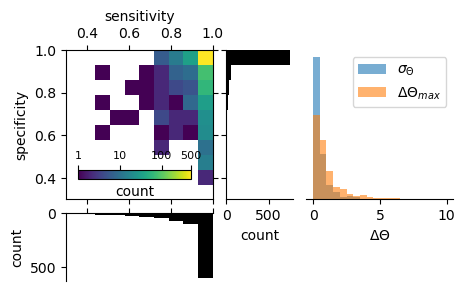

In [645]:
fig = plt.figure(figsize=(5,3))

gs = plt.GridSpec(3,5)
# idx = parameters['inferred']['matched']['n_fields'] == 2

idx = fields_match

frac_array = np.linspace(0.3,1,11)
ax_sensitivity = fig.add_subplot(gs[2,:2])
ax_sensitivity.hist(sensitivity[idx,:].flatten(),bins=frac_array,color='k')
ax_sensitivity.invert_yaxis()
ax_sensitivity.spines[['bottom','right']].set_visible(False)
plt.setp(ax_sensitivity,ylabel='count',xlim=frac_array[[0,-1]],xticklabels=[],xticks=np.linspace(.4,1,4))
ax_sensitivity.tick_params(top=True, labeltop=False, bottom=False, labelbottom=False)

ax_specificity = fig.add_subplot(gs[:2,2])
ax_specificity.hist(specificity[idx,:].flatten(),bins=frac_array,orientation='horizontal',color='k')
ax_specificity.spines[['top','right']].set_visible(False)
plt.setp(ax_specificity,xlabel='count',ylim=frac_array[[0,-1]],yticklabels=[],yticks=np.linspace(.4,1,4))


hist_sens, _, _ = np.histogram2d(sensitivity[idx,:].flatten(),specificity[idx,:].flatten(),bins=[frac_array,frac_array])

hist_sens[hist_sens==0] = np.NaN

ax_both = fig.add_subplot(gs[:2,:2])
# img = ax_both.imshow(np.log(hist_sens),origin='lower',extent=[0.5,1,0.5,1],aspect='auto')
X,Y = np.meshgrid(frac_array,frac_array)
img = ax_both.pcolormesh(X,Y,np.log(hist_sens))#,origin='lower',extent=[0.5,1,0.5,1],aspect='auto')
# ax_both.hist2d(sensitivity[idx,:].flatten(),specificity[idx,:].flatten(),bins=[frac_array,frac_array],cmap='viridis',density=True)
plt.setp(ax_both,xlabel='sensitivity',ylabel='specificity',xticks=np.linspace(0.4,1,4),yticks=np.linspace(.4,1,4))
ax_both.tick_params(top=True, labeltop=True, bottom=True, labelbottom=False,left=True, labelleft=True,right=True, labelright=False)
ax_both.xaxis.set_label_position('top') 

cax = fig.add_subplot([0.15,0.45,0.225,0.03])
cbar = plt.colorbar(img,cax=cax,orientation='horizontal')
cbar.set_label('count')
cax.xaxis.set_ticks_position('top')
tick_positions = [1,10,100,500]
plt.setp(cax,xticks=np.log(tick_positions),xticklabels=tick_positions)
cbar.ax.tick_params(labelsize=8)


ax = fig.add_subplot(gs[:2,3:])
ax.hist(theta_std.flatten(),bins=np.linspace(0,10,21),alpha=0.6,label='$\sigma_{\Theta}$')

# plt.setp(ax,xlabel='$\sigma_{\Theta}$')
ax.spines[['top','right']].set_visible(False)

# ax = fig.add_subplot(122)
ax.hist(dtheta_max.flatten(),bins=np.linspace(0,10,21),alpha=0.6,label='$\Delta \Theta_{max}$')
plt.setp(ax,xlabel='$\Delta\Theta$',yticks=[])
ax.spines[['top','right','left']].set_visible(False)

ax.legend()
# specificity

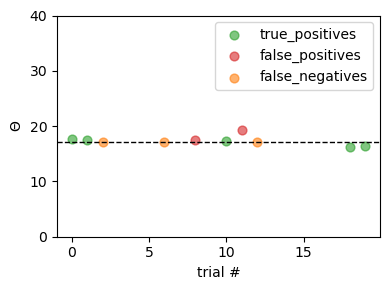

In [585]:

# idxes = fields_match & (parameters['truth']['n_fields']==1) & (sensitivity[:,0] < 1.) & (specificity[:,0] < 1.)
# idx = np.random.choice(np.where(idxes)[0],1)
# print(idx)
idx = 197

idxes = {
	'true_positives': np.logical_and(surrogate_data.field_activation[idx,0]>0.5,results['fields']['active_trials'][idx,0]>0.5),
	'false_positives': np.logical_and(surrogate_data.field_activation[idx,0]<0.5,results['fields']['active_trials'][idx,0]>0.5),
	# 'true_negatives': np.logical_and(surrogate_data.field_activation[idx,0]<0.5,results['fields']['active_trials'][idx,0]<0.5),
	'false_negatives': np.logical_and(surrogate_data.field_activation[idx,0]>0.5,results['fields']['active_trials'][idx,0]<0.5)
}

theta_total = results['fields']['parameter']['global']['theta'][idx,0,0]
theta_local = results['fields']['parameter']['local']['theta'][idx,0,:,0]

theta_local[idxes['false_negatives']] = theta_total

fig = plt.figure(figsize=(4,3))
ax_activation = fig.add_subplot(111)

col = ['tab:green','tab:red','tab:orange']
ax_activation.axhline(theta_total,linestyle='--',color='k',lw=1)
for i, key in enumerate(idxes.keys()):
	ax_activation.scatter(
		np.where(idxes[key])[0],
		theta_local[idxes[key]],
		marker="o",
		c=col[i],
		s=40,
		alpha=0.6,
		label=key if f == 0 else None,
	)
ax_activation.legend()

# ax.hist2d(surrogate_data.field_activation[idx,0],results['fields']['active_trials'][idx,0],bins=[np.linspace(0,1,21),np.linspace(0,1,21)],cmap='viridis',density=True)
plt.setp(ax_activation,ylim=[0,nbin],xlabel='trial #',ylabel='$\Theta$')
plt.tight_layout()




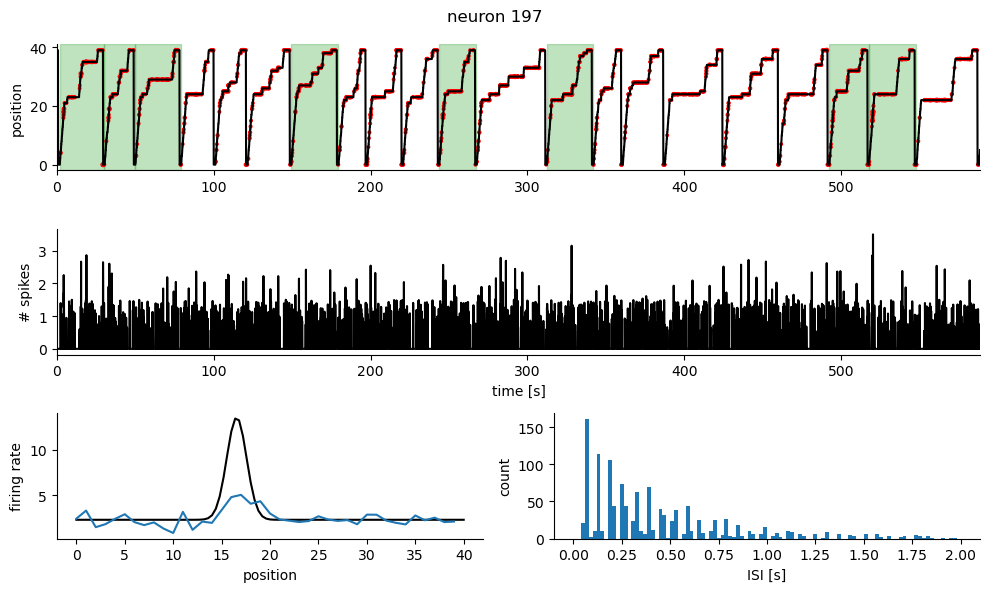

sensitivity=array([0.625]), specificity=array([0.84615385])
A0: [2.32272024] vs 1.9240069189164175
PF1_A: [11.22202278] vs 7.400745690302318
PF1_sigma: [1.01993504] vs 1.259310810890919


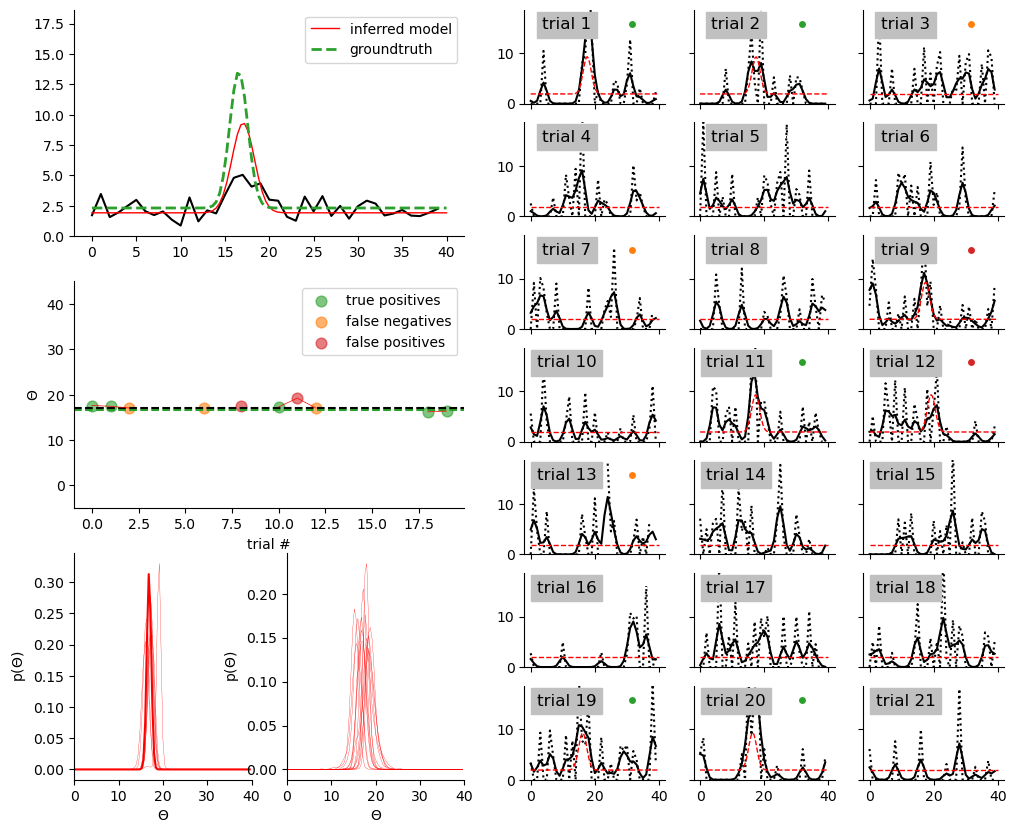

In [652]:
from display_inference_results import display_results

idx=197
surrogate_data.plot_activity(idx)

display_results(results,idx,
	surrogate_data.tuning_curve_parameter[197],
    surrogate_data.field_activation[197])

In [662]:
def plot_vars_methods(ax,var,bins,method='peak'):

	fact = 1 if var=='A0' else 2

	idx_detected = results['status']['is_place_cell'][f'{method}_method']
	idx_failed = ~idx_detected

	vals = np.full((fact*n_cells,2),np.NaN)
	vals[:fact*idx_detected.sum(),0] = parameters_bare[var][idx_detected].flatten()
	vals[:fact*idx_failed.sum(),1] = parameters_bare[var][idx_failed].flatten()

	ax.hist(vals,bins=bins,alpha=0.6,color=['tab:green','tab:red'],label=['detected','missed'],histtype='bar',stacked=True)

	values = np.full((len(bins)-1,3),np.NaN)
	for i in range(2):
		values[:,i], x = np.histogram(vals[:,i],bins=bins)
	
	plt.setp(ax,xlabel=var,yticks=[])
	ax.spines[['top','left','right']].set_visible(False)

	ax_fraction = ax.twinx()
	ax_fraction.plot(bins[:-1],gauss_smooth(values[:,0]/values.sum(axis=1),1,mode='constant'),color='tab:red',label='separated')
	plt.setp(ax_fraction,ylim=[0,1])
	ax_fraction.spines[['top','left']].set_visible(False)

In [667]:
def get_method_evaluation(method='peak'):
	fig = plt.figure(figsize=(8,5))
	gs = plt.GridSpec(2,3)
	ax = fig.add_subplot(gs[0,0])
	plot_vars_methods(ax,'A0',np.linspace(2,4,21),method=method)
	ax = fig.add_subplot(gs[0,1])
	plot_vars_methods(ax,'A',np.linspace(5,20,21),method=method)
	ax = fig.add_subplot(gs[0,2])
	plot_vars_methods(ax,'sigma',np.linspace(0,10,21),method=method)
	ax = fig.add_subplot(gs[1,0])
	plot_vars_methods(ax,'theta',np.linspace(0,40,21),method=method)
	ax = fig.add_subplot(gs[1,1])
	plot_vars_methods(ax,'reliability',np.linspace(0,1,21),method=method)
	plt.tight_layout()


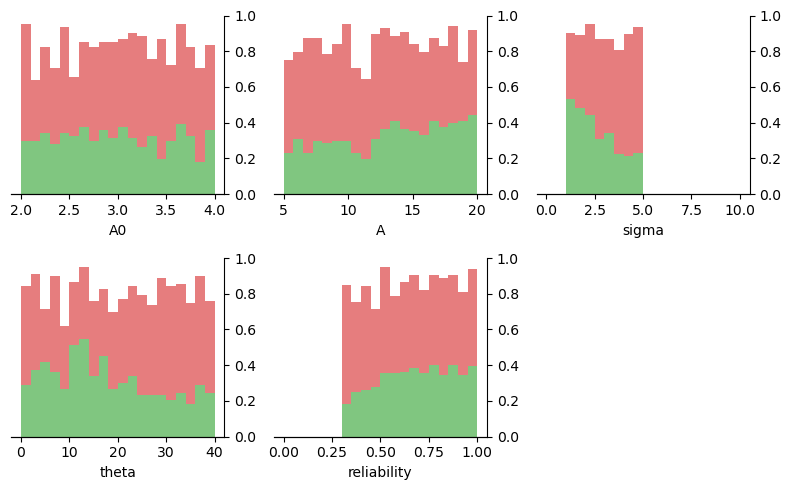

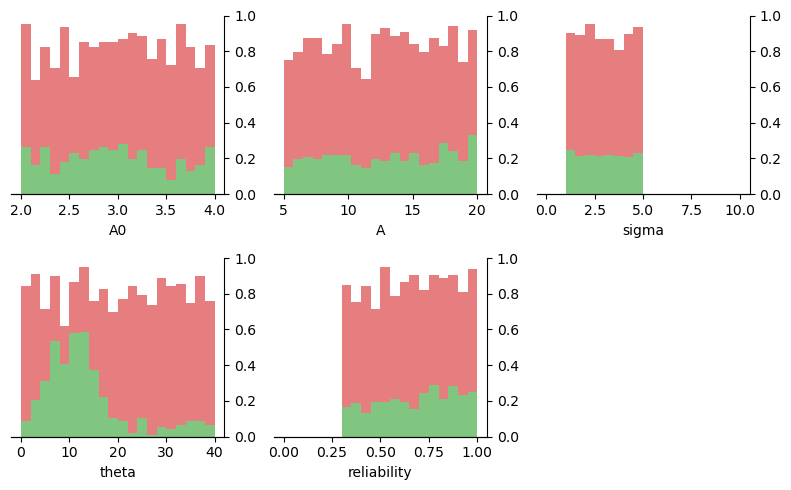

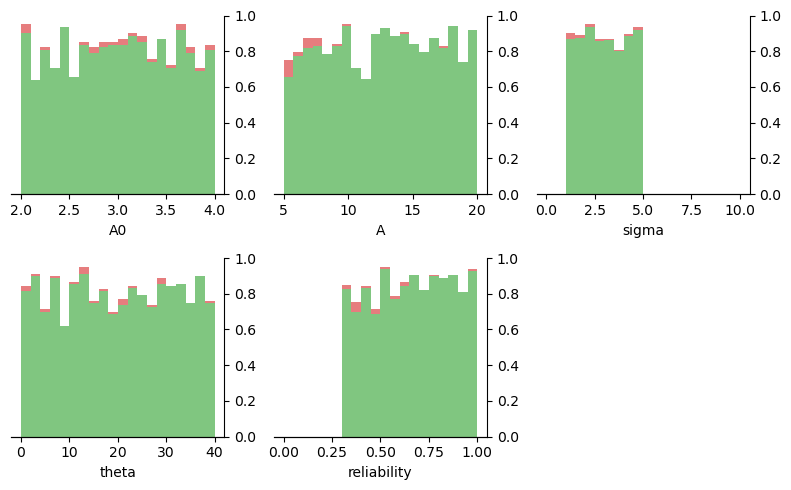

In [669]:
get_method_evaluation('peak')
get_method_evaluation('information')
get_method_evaluation('bayesian')

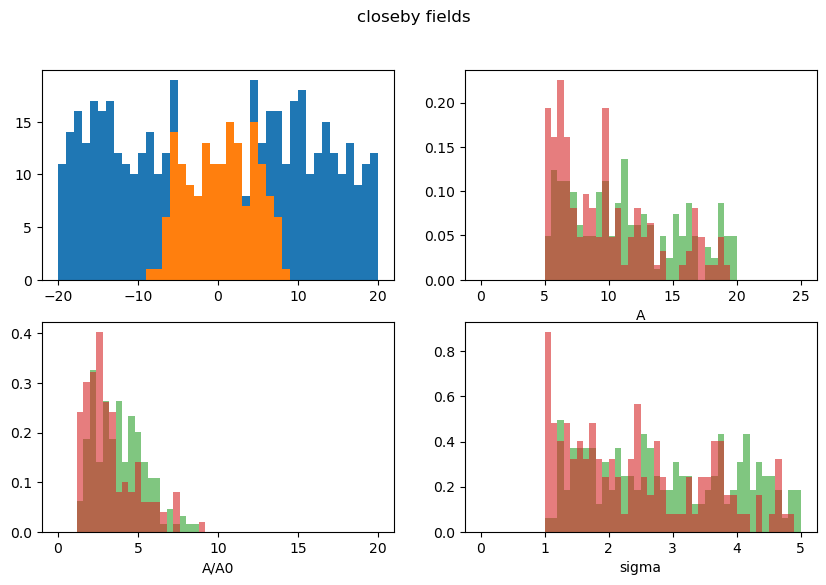

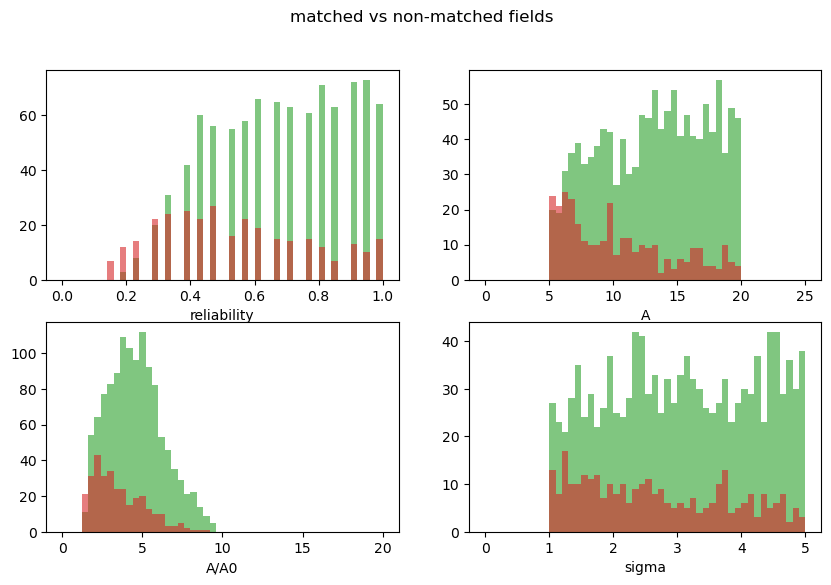

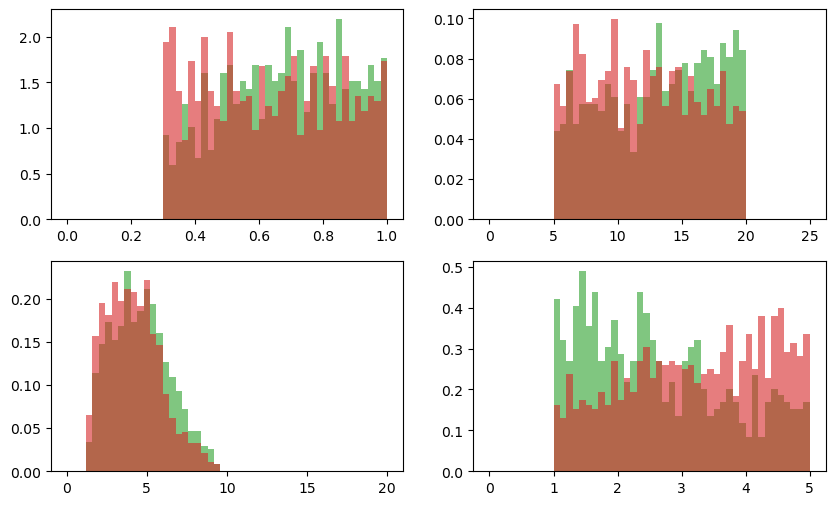

In [266]:
"""
	TODO:
		[x] write further analysis of parameter-dependent detection
		[x] get specificity and sensitivity for each cell (and plot)
		[x] get trial-activation analysis
        [ ] compare to peak and information results
"""


fig,axx = plt.subplots(2,2,figsize=(10,6))
# idx_overlap = too_close & failed_2mode_1
# idx_overlap = (np.abs(d_theta) < 5) & failed_2mode_1

# ax.hist(dTheta[failed_2mode_1],bins=np.linspace(-20,20,41))
axx[0][0].hist(d_theta,bins=np.linspace(-20,20,41))
axx[0][0].hist(d_theta[idx_overlap],bins=np.linspace(-20,20,41))

# plot_results_with_condition(parameters,idx_overlap,axx)
# ax = fig.add_subplot(221)
A_fit = parameters['truth']['nonmatched']['A'][idx_overlap]
A_nofit = parameters['truth']['nonmatched']['A'][idx_separated]
# A_fail = A_fail[np.isfinite(A_fail)]
axx[0][1].hist(A_fit[np.isfinite(A_fit)],bins=np.linspace(0,25,51),density=True,alpha=0.6,color='tab:green')
axx[0][1].hist(A_nofit[np.isfinite(A_nofit)],bins=np.linspace(0,25,51),density=True,alpha=0.6,color='tab:red')
plt.setp(axx[0][1],xlabel='A')

# ax.hist(parameters['truth']['nonmatched']['A'][idx_overlap],bins=np.linspace(0,25,26),density=True)

A_ratio_fit = parameters['truth']['nonmatched']['A'][idx_overlap] / parameters['truth']['A0'][idx_overlap,np.newaxis]
A_ratio_nofit = parameters['truth']['nonmatched']['A'][idx_separated] / parameters['truth']['A0'][idx_separated,np.newaxis]

axx[1][0].hist(A_ratio_fit[np.isfinite(A_ratio_fit)],bins=np.linspace(0,20,51),density=True,alpha=0.6,color='tab:green')
axx[1][0].hist(A_ratio_nofit[np.isfinite(A_ratio_nofit)],bins=np.linspace(0,20,51),density=True,alpha=0.6,color='tab:red')
plt.setp(axx[1][0],xlabel='A/A0')

sigma_fit = parameters['truth']['nonmatched']['sigma'][idx_overlap]
sigma_nofit = parameters['truth']['nonmatched']['sigma'][idx_separated]

axx[1][1].hist(sigma_fit[np.isfinite(sigma_fit)],bins=np.linspace(0,5,51),density=True,alpha=0.6,color='tab:green')
axx[1][1].hist(sigma_nofit[np.isfinite(sigma_nofit)],bins=np.linspace(0,5,51),density=True,alpha=0.6,color='tab:red')
plt.setp(axx[1][1],xlabel='sigma')
plt.suptitle('closeby fields ')



fig,axx = plt.subplots(2,2,figsize=(10,6))
# idx_well_inferred = np.logical_and(parameters['truth']['n_fields'] == 2, parameters['truth']['matched']['n_fields'] == 2)
# print(fields_match)
density = False
idx_perfect_match = parameters['truth']['matched']['n_fields'] == parameters['truth']['n_fields']

reliability = parameters['truth']['matched']['reliability'][idx_perfect_match]
reliability_fail = parameters['truth']['nonmatched']['reliability']
axx[0][0].hist(reliability[np.isfinite(reliability)],bins=np.linspace(0,1,51),density=density,alpha=0.6,color='tab:green')
axx[0][0].hist(reliability_fail[np.isfinite(reliability_fail)],bins=np.linspace(0,1,51),density=density,alpha=0.6,color='tab:red')
plt.setp(axx[0][0],xlabel='reliability')

A = parameters['truth']['matched']['A']
A_fail = parameters['truth']['nonmatched']['A']
axx[0][1].hist(A[np.isfinite(A)],bins=np.linspace(0,25,51),density=density,alpha=0.6,color='tab:green')
axx[0][1].hist(A_fail[np.isfinite(A_fail)],bins=np.linspace(0,25,51),density=density,alpha=0.6,color='tab:red')
plt.setp(axx[0][1],xlabel='A')

A_ratio = A / parameters['truth']['A0'][:,np.newaxis]
A_ratio_fail = A_fail / parameters['truth']['A0'][:,np.newaxis]
axx[1][0].hist(A_ratio[np.isfinite(A_ratio)],bins=np.linspace(0,20,51),density=density,alpha=0.6,color='tab:green')
axx[1][0].hist(A_ratio_fail[np.isfinite(A_ratio_fail)],bins=np.linspace(0,20,51),density=density,alpha=0.6,color='tab:red')
plt.setp(axx[1][0],xlabel='A/A0')

sigma = parameters['truth']['matched']['sigma']
sigma_fail = parameters['truth']['nonmatched']['sigma']
axx[1][1].hist(sigma[np.isfinite(sigma)],bins=np.linspace(0,5,51),density=density,alpha=0.6,color='tab:green')
axx[1][1].hist(sigma_fail[np.isfinite(sigma_fail)],bins=np.linspace(0,5,51),density=density,alpha=0.6,color='tab:red')
plt.setp(axx[1][1],xlabel='sigma')

fig.suptitle('matched vs non-matched fields')


fig, axx = plt.subplots(2,2,figsize=(10,6))

density = True
idx_detect = is_PC['peak_method']
# idx_detect = is_PC['information_method']

reliability = parameters_bare['reliability'][idx_detect]
reliability_fail = parameters_bare['reliability'][~idx_detect]
axx[0][0].hist(reliability[np.isfinite(reliability)],bins=np.linspace(0,1,51),density=density,alpha=0.6,color='tab:green')
axx[0][0].hist(reliability_fail[np.isfinite(reliability_fail)],bins=np.linspace(0,1,51),density=density,alpha=0.6,color='tab:red')


A = parameters_bare['A'][idx_detect]
A_fail = parameters_bare['A'][~idx_detect]
axx[0][1].hist(A[np.isfinite(A)],bins=np.linspace(0,25,51),density=density,alpha=0.6,color='tab:green')
axx[0][1].hist(A_fail[np.isfinite(A_fail)],bins=np.linspace(0,25,51),density=density,alpha=0.6,color='tab:red')

A_ratio = A / parameters_bare['A0'][idx_detect,np.newaxis]
A_ratio_fail = A_fail / parameters_bare['A0'][~idx_detect,np.newaxis]
axx[1][0].hist(A_ratio[np.isfinite(A_ratio)],bins=np.linspace(0,20,51),density=density,alpha=0.6,color='tab:green')
axx[1][0].hist(A_ratio_fail[np.isfinite(A_ratio_fail)],bins=np.linspace(0,20,51),density=density,alpha=0.6,color='tab:red')

sigma = parameters_bare['sigma'][idx_detect]
sigma_fail = parameters_bare['sigma'][~idx_detect]
axx[1][1].hist(sigma[np.isfinite(sigma)],bins=np.linspace(0,5,51),density=density,alpha=0.6,color='tab:green')
axx[1][1].hist(sigma_fail[np.isfinite(sigma_fail)],bins=np.linspace(0,5,51),density=density,alpha=0.6,color='tab:red')

# theta_close = parameters['truth']['nonmatched']['theta'][idx_overlap]
# theta_fail = parameters['truth']['nonmatched']['theta'][~idx_overlap]

# ax.hist(theta_fail[np.isfinite(theta_fail)],bins=np.linspace(0,track['nbin'],41),density=True,alpha=0.6)
# ax.hist(theta_close[np.isfinite(theta_close)],bins=np.linspace(0,track['nbin'],41),density=True,alpha=0.6)



plt.show(block=False)

# np.isfinite(d_theta).sum()
# (np.abs(d_theta)<7).sum()

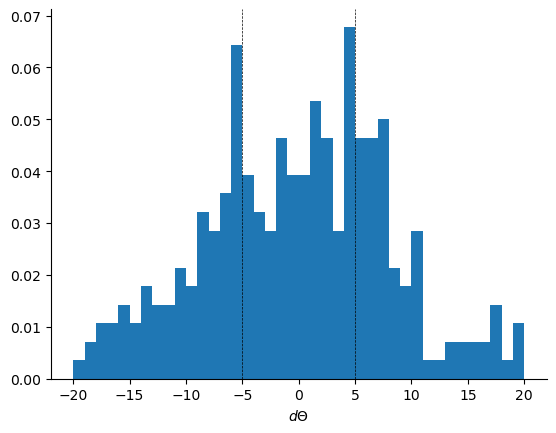

In [436]:
idx_two_fields = parameters_bare['n_fields']==2
failed_2mode = np.logical_and(parameters['truth']['n_fields'] == 2, parameters['truth']['matched']['n_fields'] != 2)
failed_2mode_1 = np.logical_and(failed_2mode, results['fields']['n_modes'] == 1)
dTheta = np.mod(np.diff(parameters_bare['theta'],axis=1)+nbin/2.,nbin)-nbin/2.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axvline(-5,color='k',ls='--',lw=0.5)
ax.axvline(5,color='k',ls='--',lw=0.5)

ax.hist(dTheta[failed_2mode_1],bins=np.linspace(-20,20,41),density=True)#,cumulative=True,histtype='step')
plt.setp(ax,xlabel='$d\Theta$')
ax.spines[['top','right']].set_visible(False)


In [240]:
surrogate_parameters['theta']
neuron = 5
print(surrogate_parameters['theta'][neuron,...])
print(surrogate_parameters['n_fields'][neuron,...])
print(results['fields']['n_modes'][neuron])
#surrogate_parameters['n_fields'][2]
#surrogate_data.tuning_curve_parameter[2]

#(surrogate_parameters['n_fields']==2).sum()

[37.97983555         nan         nan]
2.0
1


In [210]:
surrogate_parameters['theta'][:,0]

array([1.08839294e+01, 1.30669771e+01, 3.55093196e+01, 3.57491713e+00,
       2.15035419e+01, 3.79798355e+01, 2.85295631e+01, 1.50697318e+01,
       2.95554429e+00, 3.17066238e+00, 2.45430783e+01, 3.07223241e+01,
       2.28712024e+01, 3.77783802e+01, 1.91206928e+01, 2.12689625e+01,
       6.46805386e+00, 7.93262319e+00, 2.48249876e+01, 2.80386918e+01,
       2.77160788e+01, 3.54007476e+00, 1.21394299e+01, 2.94718063e+01,
       1.33134010e+01, 2.09780861e+01, 2.97152718e+01, 3.55462004e+01,
       1.45148104e+01, 6.77998831e+00, 2.87671262e+01, 3.98134125e+01,
                  nan, 3.78837374e+00,            nan, 1.90744785e+01,
       1.09779142e+00, 2.02211672e+01, 2.73951146e+01, 1.19947160e+01,
       1.17423122e+01, 1.22060983e+01, 7.51973265e-01, 1.42302748e+01,
       8.95944740e-01, 1.30114568e+01, 6.79204015e+00, 3.23304364e+01,
       1.67064374e+01, 1.61856601e+01, 5.25678287e+00, 4.79862709e+00,
       3.80063581e+01, 2.74179990e+01, 3.67418198e+01, 1.71298635e+01,
      

sensitivity=array([0.7]), specficity=array([0.54545455])
A0: 3.988112331467224 vs 4.165894256315229
PF1_A: 12.08548390322946 vs 16.314281704454604
PF1_sigma: 1.1761498359642761 vs 0.6763187738588139


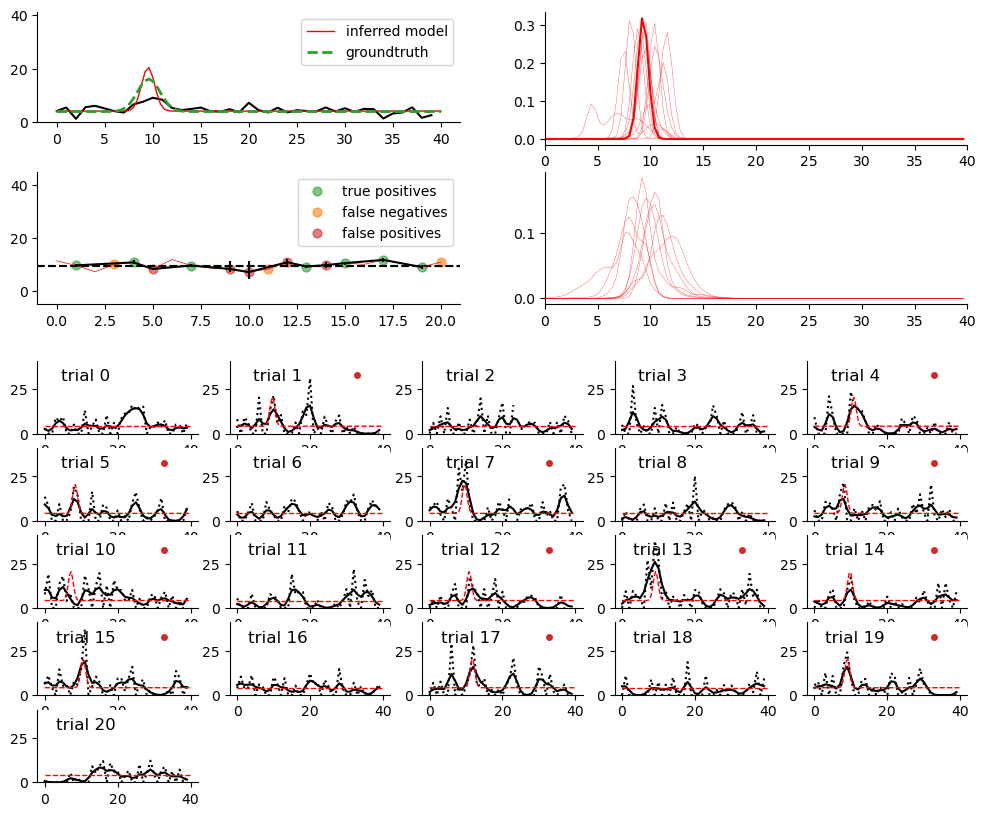

In [129]:
from display_inference_results import display_results
neuron = 750

display_results(
    results,
    neuron,
    groundtruth_fields=surrogate_data.tuning_curve_parameter[neuron],
    groundtruth_activation=surrogate_data.field_activation[neuron,...]
)

In [117]:
int(np.ceil(21/8))

3

In [57]:
results['fields']['logz'][neuron,...]
# results['status']['is_place_cell']['bayesian_method']
# results['fields']['n_modes']
# results['fields']['active_trials'][3,...]
# results['fields']['parameter']['global']['theta'][3,...]

"""
	TODO:
		- how to compare, when 2 fields are generated and overlapping strongly?
"""

array([[-1.11558820e+03,  2.08616684e-01],
       [-1.08660970e+03,  5.61147377e-01],
       [-1.10748643e+03,  4.42314008e-01]])

In [62]:
import logging
from HierarchicalBayesInference import HierarchicalBayesInference

neuron = 10
nbin = 40

activity = prepare_activity(surrogate_data.activity[neuron,:],behavior['active'],behavior['trials'],nbin=nbin)
# activity = prepare_activity(activity_single,behavior['active'],behavior['trials'],nbin=nbin)

hierarchical = ['theta']
wrap = []

hbm = HierarchicalBayesInference(
	activity['spike_map'],
	behavior['trials']['dwelltime'],
	nbin,
	logLevel=logging.ERROR,
)

single_result = hbm.model_comparison(hierarchical=['theta'],plot=False)

Model comparison finished after 48.06s with evidences: 	 f=0 , logz=-1287.80	 f=1 , logz=-1170.47	 f=2 *, logz=-1148.96


sensitivity=array([0.6, 1. ]), specficity=array([1., 1.])
A0: [3.7466364] vs 3.0286865770398115
PF1_A: [5.50994282] vs 6.7361411417683925
PF1_sigma: [3.32963978] vs 3.732202833916138
PF2_A: [16.47326788] vs 18.05079892493783
PF2_sigma: [2.32270533] vs 2.1980308813207574


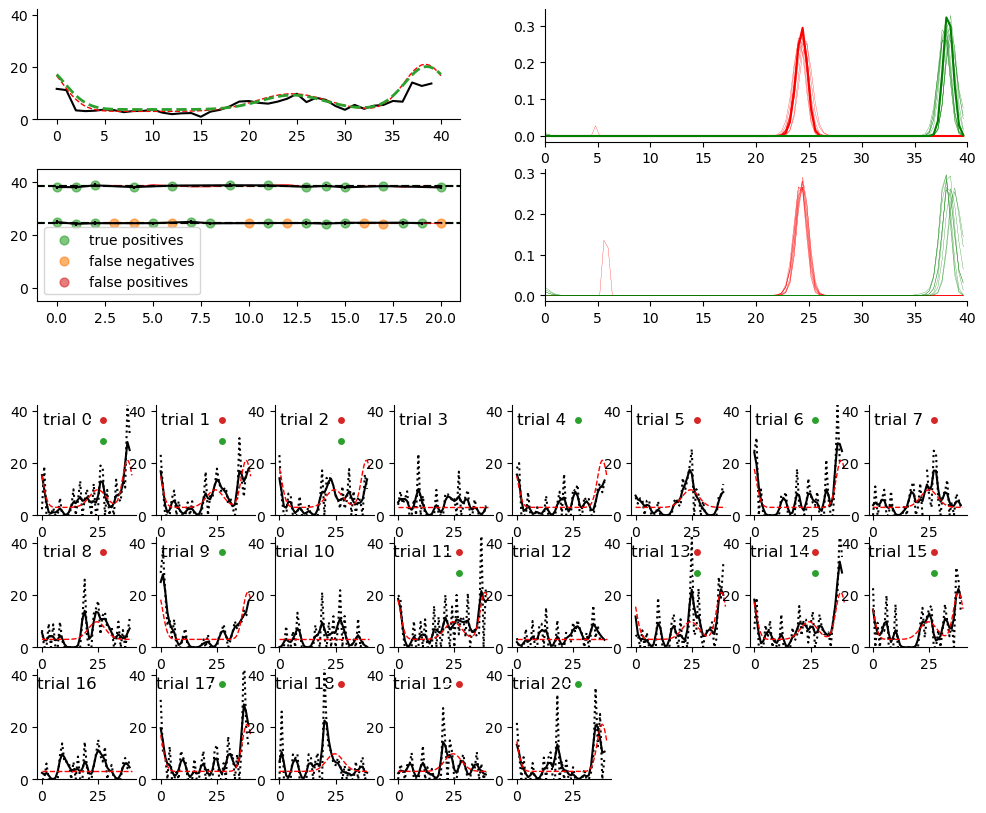

In [99]:
display_results(
    single_result,
    groundtruth_activation=surrogate_data.field_activation[neuron,...],
    groundtruth_fields=surrogate_data.tuning_curve_parameter[neuron]
)